Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Используйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

pd.set_option('display.float_format', lambda x: f"{x:.4f}")

DATA_PATH = '/Users/victoriasamsonova/bsu/oiad/oiad-11-2025/datasets/famcs_students.csv'

df = pd.read_csv(DATA_PATH)
print(f"Размер данных: {df.shape}")
print(f"\nСтолбцы: {df.columns.tolist()}")
print(f"\nПервые строки:")
print(df.head())

Размер данных: (127, 25)

Столбцы: ['cource', 'group', 'stream', 'sex', 'age', 'ss', 'interest', 'os', 'weekend_study', 'bad_sleep', 'glasses', 'work_experience', 'ai', 'height', 'anime', 'social', 'sport', 'miss', 'study_form', 'foot_size', 'eye_color', 'score', 'retake', 'hostel', 'literature']

Первые строки:
   cource  group                  stream sex     age   ss          interest  \
0       4     11  Прикладная информатика   М 20.0000  Нет        Математика   
1       4     11  Прикладная информатика   Ж 20.0000  Нет  Программирование   
2       4     11  Прикладная информатика   Ж 19.0000  Нет  Программирование   
3       4     11  Прикладная информатика   Ж 20.0000  Нет        Математика   
4       4     11  Прикладная информатика   М 20.0000  Нет        Математика   

        os weekend_study bad_sleep  ...      social  \
0    MacOS            Да        Да  ...  Экстраверт   
1    MacOS           Нет       Нет  ...  Экстраверт   
2    MacOS            Да       Нет  ...  Экстр

In [16]:
N = 16  
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

target_col_idx = N % 8
target_col = binary_cols[target_col_idx]
print(f"N = {N}, target_col_idx = {target_col_idx}")
print(f"Целевая переменная: {target_col}")

y = df[target_col].copy()

if target_col == 'interest':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    median_val = np.median(y_encoded)
    y = (y_encoded > median_val).astype(int)
    print(f"Уникальные значения interest: {df[target_col].unique()}")
    print(f"Медиана: {median_val}, бинарные классы: {np.bincount(y)}")
elif target_col == 'study_form':
    y = (y == 'Платная').astype(int)
    print(f"Уникальные значения study_form: {df[target_col].unique()}")
    print(f"Бинарные классы: {np.bincount(y)}")
else:
    y = (y == 'Да').astype(int)
    print(f"Уникальные значения {target_col}: {df[target_col].unique()}")
    print(f"Бинарные классы: {np.bincount(y)}")

print(f"\nРаспределение классов: {np.bincount(y)}")
print(f"Доля класса 1: {y.mean():.3f}")


N = 16, target_col_idx = 0
Целевая переменная: ss
Уникальные значения ss: ['Нет' 'Да']
Бинарные классы: [113  14]

Распределение классов: [113  14]
Доля класса 1: 0.110


In [17]:
feature_cols = [col for col in df.columns if col not in binary_cols]
print(f"Признаки (исключая binary_cols): {feature_cols}")

selected_features = ['age', 'sex', 'cource', 'group', 'stream', 'os', 'work_experience', 
                     'ai', 'height', 'social', 'sport', 'miss', 'foot_size', 'eye_color', 
                     'score', 'retake', 'hostel']

selected_features = [f for f in selected_features if f in df.columns]
print(f"\nВыбранные признаки ({len(selected_features)}): {selected_features}")

X = df[selected_features].copy()

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 0)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42, stratify=y_temp
)

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"\nКатегориальные признаки для кодирования: {categorical_cols}")

frequency_encoders = {}
for col in categorical_cols:
    freq_map = X_train[col].value_counts(normalize=True).to_dict()
    frequency_encoders[col] = freq_map
    
    X_train[col] = X_train[col].map(freq_map).fillna(0)  
    X_val[col] = X_val[col].map(freq_map).fillna(0)
    X_test[col] = X_test[col].map(freq_map).fillna(0)
    
    print(f"{col}: закодировано {len(freq_map)} уникальных значений")

X_train = X_train.values.astype(float)
X_val = X_val.values.astype(float)
X_test = X_test.values.astype(float)
y_train = y_train.values.astype(int)
y_val = y_val.values.astype(int)
y_test = y_test.values.astype(int)

print(f"\nФинальная форма X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Финальная форма X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Финальная форма X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Пропуски в X_train: {np.isnan(X_train).sum()}, в X_val: {np.isnan(X_val).sum()}, в X_test: {np.isnan(X_test).sum()}")


Признаки (исключая binary_cols): ['cource', 'group', 'stream', 'sex', 'age', 'os', 'work_experience', 'ai', 'height', 'social', 'sport', 'miss', 'foot_size', 'eye_color', 'score', 'retake', 'hostel']

Выбранные признаки (17): ['age', 'sex', 'cource', 'group', 'stream', 'os', 'work_experience', 'ai', 'height', 'social', 'sport', 'miss', 'foot_size', 'eye_color', 'score', 'retake', 'hostel']

Категориальные признаки для кодирования: ['sex', 'stream', 'os', 'work_experience', 'ai', 'social', 'sport', 'eye_color', 'retake', 'hostel']
sex: закодировано 2 уникальных значений
stream: закодировано 3 уникальных значений
os: закодировано 3 уникальных значений
work_experience: закодировано 4 уникальных значений
ai: закодировано 12 уникальных значений
social: закодировано 3 уникальных значений
sport: закодировано 3 уникальных значений
eye_color: закодировано 4 уникальных значений
retake: закодировано 3 уникальных значений
hostel: закодировано 3 уникальных значений

Финальная форма X_train: (88, 17

In [18]:
print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"Val: {X_val.shape[0]} ({X_val.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"\nРаспределение классов в train: {np.bincount(y_train)}")
print(f"Распределение классов в val: {np.bincount(y_val)}")
print(f"Распределение классов в test: {np.bincount(y_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train: 88 (69.3%)
Val: 19 (15.0%)
Test: 20 (15.7%)

Распределение классов в train: [78 10]
Распределение классов в val: [17  2]
Распределение классов в test: [18  2]


## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [19]:
class TrivialClassifier:
    def __init__(self):
        self.most_common_class = None
    
    def fit(self, X, y):
        self.most_common_class = stats.mode(y, keepdims=True)[0][0]
        return self
    
    def predict(self, X):
        return np.full(X.shape[0], self.most_common_class)
    
    def predict_proba(self, X):
        n = X.shape[0]
        prob = np.zeros((n, 2))
        prob[:, self.most_common_class] = 1.0
        return prob

trivial_clf = TrivialClassifier()
trivial_clf.fit(X_train, y_train)
y_pred_trivial = trivial_clf.predict(X_test)
y_proba_trivial = trivial_clf.predict_proba(X_test)[:, 1]

print(f"Наиболее частый класс: {trivial_clf.most_common_class}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_trivial):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_trivial, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_trivial, zero_division=0):.4f}")
print(f"F1: {f1_score(y_test, y_pred_trivial, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_trivial):.4f}")


Наиболее частый класс: 0
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC-AUC: 0.5000


## 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!

In [21]:
class NaiveBayes:
    def __init__(self):
        self.prior = None
        self.mean = None
        self.var = None
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        
        self.prior = np.array([np.mean(y == c) for c in self.classes])
        
        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[i] = X_c.mean(axis=0)
            self.var[i] = X_c.var(axis=0) + 1e-9  
        
        return self
    
    def _gaussian_pdf(self, x, mean, var):
        """Плотность нормального распределения"""
        return np.exp(-0.5 * ((x - mean) ** 2) / var) / np.sqrt(2 * np.pi * var)
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_proba = np.zeros((n_samples, n_classes))
        
        for i, c in enumerate(self.classes):
            log_proba[:, i] = np.log(self.prior[i] + 1e-9)
            
            for j in range(X.shape[1]):
                log_proba[:, i] += np.log(self._gaussian_pdf(X[:, j], self.mean[i, j], self.var[i, j]) + 1e-9)
        
        log_proba_max = log_proba.max(axis=1, keepdims=True)
        log_proba -= log_proba_max
        proba = np.exp(log_proba)
        proba /= proba.sum(axis=1, keepdims=True)
        
        return proba
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes[np.argmax(proba, axis=1)]

nb_clf = NaiveBayes()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)
y_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

print("Наивный байесовский классификатор:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nb, zero_division=0):.4f}")
print(f"F1: {f1_score(y_test, y_pred_nb, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_nb):.4f}")


Наивный байесовский классификатор:
Accuracy: 0.7000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC-AUC: 0.1667


## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.

Оптимальный k: 10 (ROC-AUC на валидации: 0.6765)


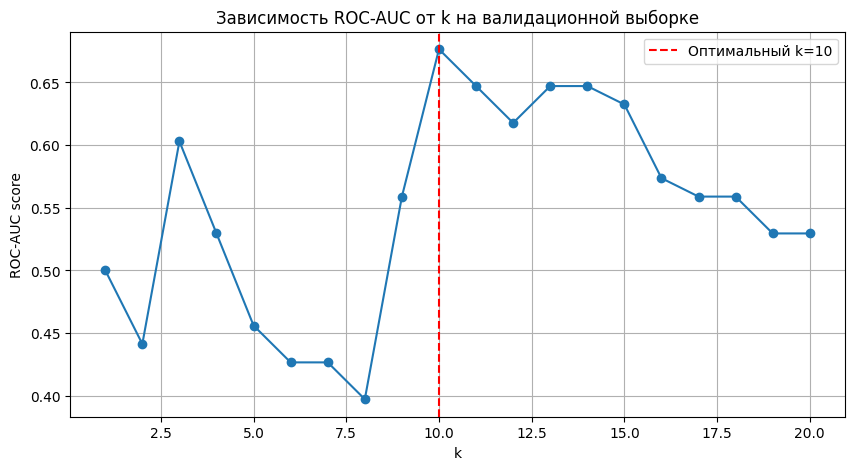


KNN классификатор:
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC-AUC: 0.2361


In [22]:
class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros(n_samples)
        
        for i in range(n_samples):
            distances = self._euclidean_distance(X[i:i+1], self.X_train)
            
            k_indices = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_indices]
            
            proba[i] = np.mean(k_labels)
        
        return np.column_stack([1 - proba, proba])
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

k_values = range(1, 21)
best_k = 1
best_val_roc_auc = 0

val_roc_auc_scores = []

for k in k_values:
    knn = KNN(k=k)
    knn.fit(X_train_scaled, y_train)
    y_proba_val = knn.predict_proba(X_val_scaled)[:, 1]
    roc_auc = roc_auc_score(y_val, y_proba_val)
    val_roc_auc_scores.append(roc_auc)
    
    if roc_auc > best_val_roc_auc:
        best_val_roc_auc = roc_auc
        best_k = k

print(f"Оптимальный k: {best_k} (ROC-AUC на валидации: {best_val_roc_auc:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(k_values, val_roc_auc_scores, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Оптимальный k={best_k}')
plt.xlabel('k')
plt.ylabel('ROC-AUC score')
plt.title('Зависимость ROC-AUC от k на валидационной выборке')
plt.legend()
plt.grid(True)
plt.show()

knn_clf = KNN(k=best_k)
knn_clf.fit(X_train_scaled, y_train)
y_pred_knn = knn_clf.predict(X_test_scaled)
y_proba_knn = knn_clf.predict_proba(X_test_scaled)[:, 1]

print("\nKNN классификатор:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"F1: {f1_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_knn):.4f}")


## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

Оптимальный порог: 0.0404 (F1: 0.2222)


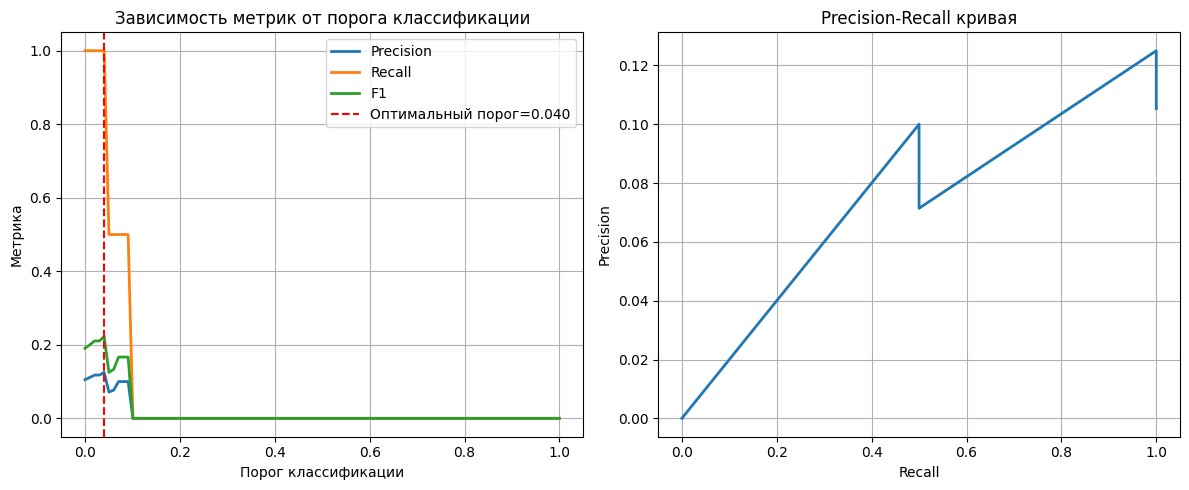


Логистическая регрессия:
Accuracy: 0.1000
Precision: 0.0556
Recall: 0.5000
F1: 0.1000
ROC-AUC: 0.2778


In [23]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iters=10000, tol=1e-6):
        self.lr = lr
        self.n_iters = n_iters
        self.tol = tol
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        
        X_b = np.hstack([np.ones((n_samples, 1)), X])
        w_b = np.hstack([self.bias, self.weights])
        
        prev_loss = np.inf
        
        for i in range(self.n_iters):
            z = X_b @ w_b
            y_pred = self._sigmoid(z)
            
            dw = (1 / n_samples) * X_b.T @ (y_pred - y)
            
            w_b -= self.lr * dw
            
            if i % 100 == 0:
                loss = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
                if abs(prev_loss - loss) < self.tol:
                    break
                prev_loss = loss
        
        self.bias = w_b[0]
        self.weights = w_b[1:]
        return self
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        X_b = np.hstack([np.ones((n_samples, 1)), X])
        w_b = np.hstack([self.bias, self.weights])
        z = X_b @ w_b
        proba = self._sigmoid(z)
        return np.column_stack([1 - proba, proba])
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

lr_clf = LogisticRegression(lr=0.01, n_iters=10000)
lr_clf.fit(X_train_scaled, y_train)

y_proba_val = lr_clf.predict_proba(X_val_scaled)[:, 1]

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_val >= threshold).astype(int)
    prec = precision_score(y_val, y_pred_thresh, zero_division=0)
    rec = recall_score(y_val, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Оптимальный порог: {best_threshold:.4f} (F1: {best_f1:.4f})")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1', linewidth=2)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Оптимальный порог={best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от порога классификации')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred_lr = lr_clf.predict(X_test_scaled, threshold=best_threshold)
y_proba_lr = lr_clf.predict_proba(X_test_scaled)[:, 1]

print("\nЛогистическая регрессия:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"F1: {f1_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")


## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок

Сводная таблица результатов на тестовой выборке:
                 Модель  Accuracy  Precision  Recall     F1  ROC-AUC
            Тривиальный    0.9000     0.0000  0.0000 0.0000   0.5000
          Наивный Байес    0.7000     0.0000  0.0000 0.0000   0.1667
                    KNN    0.9000     0.0000  0.0000 0.0000   0.2361
Логистическая регрессия    0.1000     0.0556  0.5000 0.1000   0.2778

Матрица ошибок - Тривиальный:
[[18  0]
 [ 2  0]]

Матрица ошибок - Наивный Байес:
[[14  4]
 [ 2  0]]

Матрица ошибок - KNN:
[[18  0]
 [ 2  0]]

Матрица ошибок - Логистическая регрессия:
[[ 1 17]
 [ 1  1]]


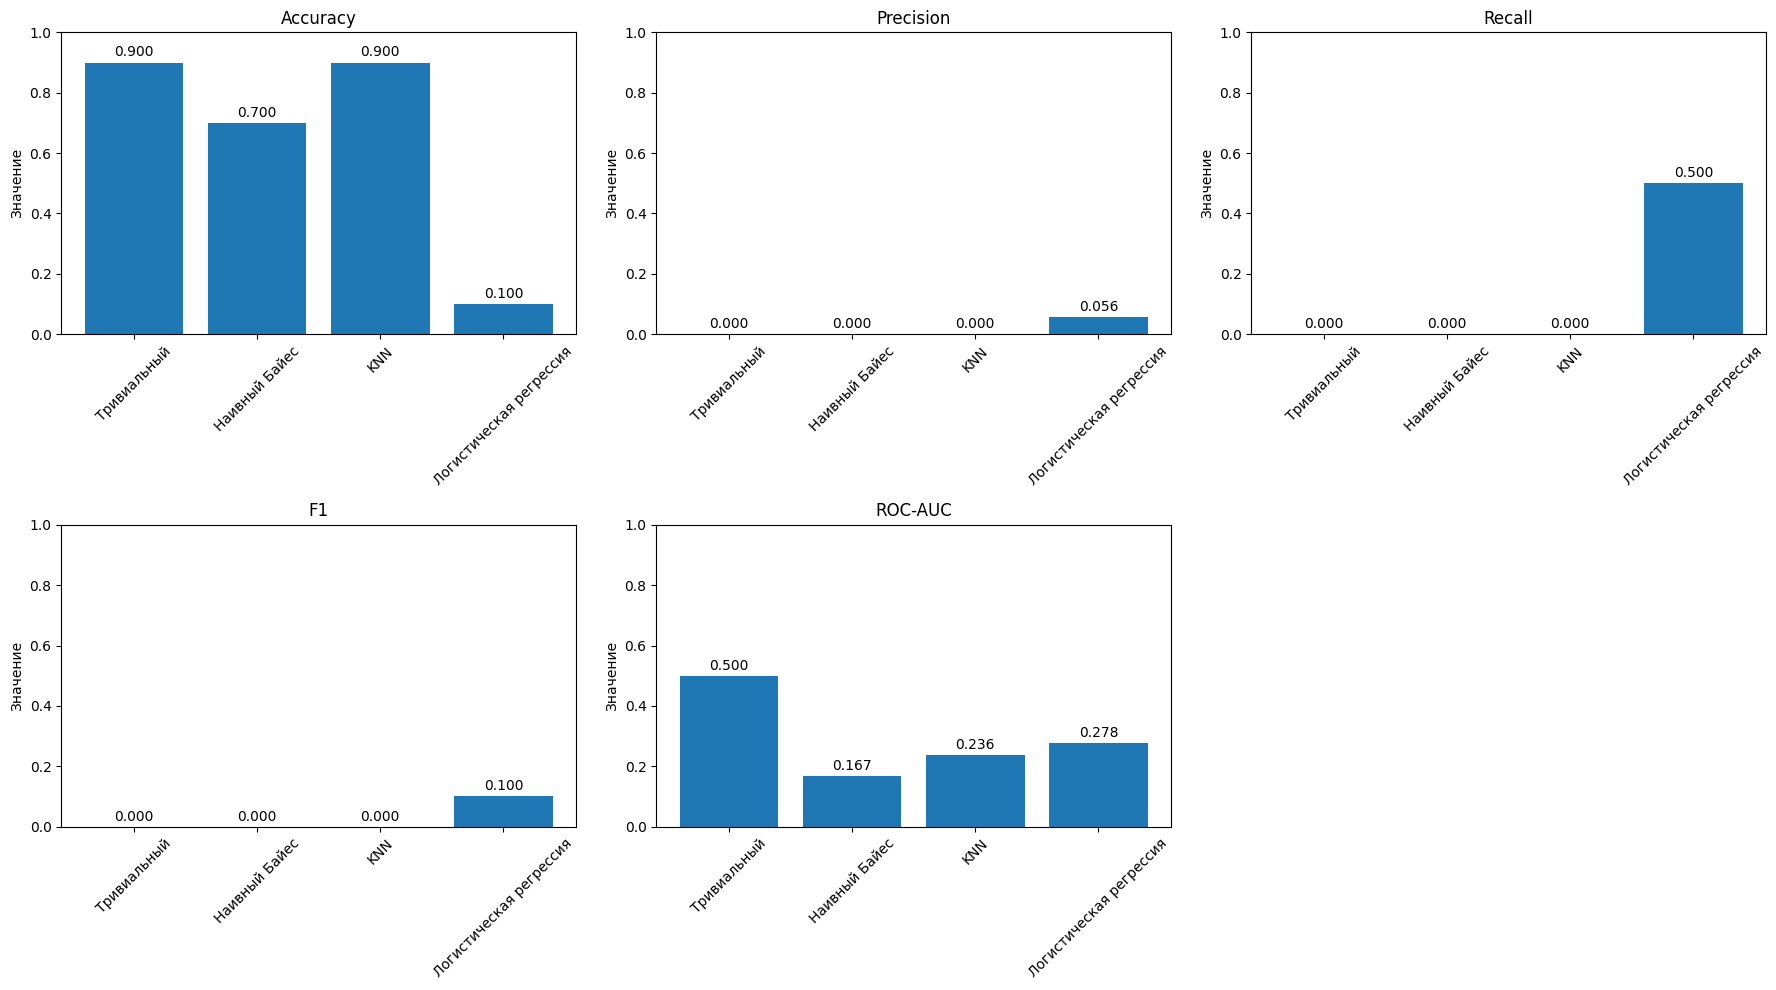

In [24]:
results = {
    'Модель': ['Тривиальный', 'Наивный Байес', 'KNN', 'Логистическая регрессия'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_trivial),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision': [
        precision_score(y_test, y_pred_trivial, zero_division=0),
        precision_score(y_test, y_pred_nb, zero_division=0),
        precision_score(y_test, y_pred_knn, zero_division=0),
        precision_score(y_test, y_pred_lr, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_trivial, zero_division=0),
        recall_score(y_test, y_pred_nb, zero_division=0),
        recall_score(y_test, y_pred_knn, zero_division=0),
        recall_score(y_test, y_pred_lr, zero_division=0)
    ],
    'F1': [
        f1_score(y_test, y_pred_trivial, zero_division=0),
        f1_score(y_test, y_pred_nb, zero_division=0),
        f1_score(y_test, y_pred_knn, zero_division=0),
        f1_score(y_test, y_pred_lr, zero_division=0)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_trivial),
        roc_auc_score(y_test, y_proba_nb),
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_lr)
    ]
}

results_df = pd.DataFrame(results)
print("Сводная таблица результатов на тестовой выборке:")
print(results_df.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    ax.bar(results_df['Модель'], results_df[metric])
    ax.set_title(metric)
    ax.set_ylabel('Значение')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

predictions = [y_pred_trivial, y_pred_nb, y_pred_knn, y_pred_lr]
model_names = ['Тривиальный', 'Наивный Байес', 'KNN', 'Логистическая регрессия']

ax = axes[1, 2]
ax.axis('off')
for i, (pred, name) in enumerate(zip(predictions, model_names)):
    cm = confusion_matrix(y_test, pred)
    print(f"\nМатрица ошибок - {name}:")
    print(cm)

plt.tight_layout()
plt.show()


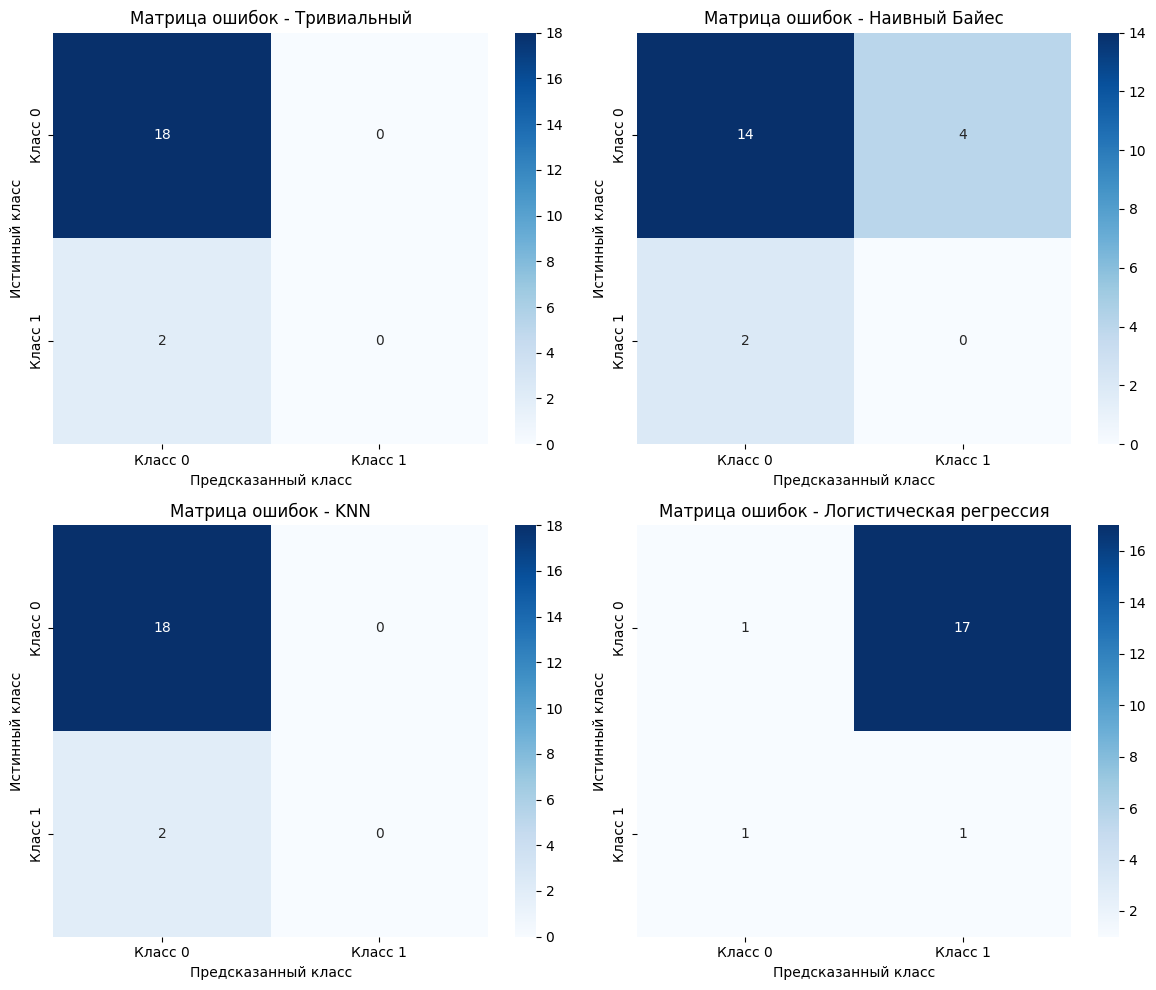

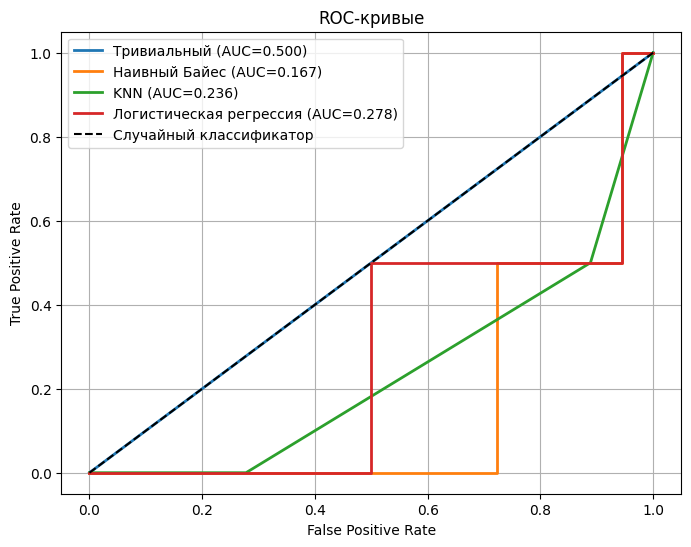

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

predictions = [y_pred_trivial, y_pred_nb, y_pred_knn, y_pred_lr]
model_names = ['Тривиальный', 'Наивный Байес', 'KNN', 'Логистическая регрессия']

for idx, (pred, name) in enumerate(zip(predictions, model_names)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Класс 0', 'Класс 1'], 
                yticklabels=['Класс 0', 'Класс 1'])
    axes[idx].set_title(f'Матрица ошибок - {name}')
    axes[idx].set_ylabel('Истинный класс')
    axes[idx].set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

probas = [y_proba_trivial, y_proba_nb, y_proba_knn, y_proba_lr]

for proba, name in zip(probas, model_names):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC-кривые')
ax.legend()
ax.grid(True)
plt.show()
